#### Text Classification using Word Embeddings of Libraries
1. Spacy Embeddings + RandomForest
2. Spacy Embeddings + Neural Networks
3. Genism FastText Embeddings + RandomForest
4. Genism FastText Embeddings + Neural Networks

In [87]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy
from gensim.models import FastText
# from nltk import sent_tokenize, word_tokenize
from tensorflow import keras

Dataset Loading and Preprocessing

In [110]:
# Dataset Loading
df = pd.read_csv('ecommerce_dataset.csv', header=None, names=['Category', 'Description'])
print(df.shape)
df.head()

(50425, 2)


,Category,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [111]:
# Label Preprocessing
df.dropna(inplace=True)
df['Category'] = df['Category'].str.replace('&', '_')
df['Category'] = df['Category'].str.replace(' ', '')
df['Category'].unique()

array(['Household', 'Books', 'Clothing_Accessories', 'Electronics'],
      dtype=object)

In [112]:
# Description Preprocessing
def remove_stop_words(text):
    stopwords_list = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(filtered_words)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['Description'] = df['Description'].apply(remove_stop_words).apply(remove_punctuation).str.lower()
df.head()

,Category,Description
0,Household,paper plane design framed wall hanging motivat...
1,Household,saf floral framed painting wood 30 inch x 10 i...
2,Household,saf uv textured modern art print framed painti...
3,Household,saf flower print framed painting synthetic 135...
4,Household,incredible gifts india wooden happy birthday u...


Basic Model Setup

In [113]:
def confusion_matrix_report(y_true, y_pred):
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
def train_and_predict(model, x_train, y_train, x_test, y_test):
    print(f"Training {model.__class__.__name__}...")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    confusion_matrix_report(y_test, y_pred)
    return accuracy

In [114]:
rfc = RandomForestClassifier()

Spacy Word Embeddings + RandomForest

In [130]:
nlp = spacy.load('en_core_web_sm')
df_spacy = df.copy()
df_spacy['embeddings'] = df_spacy['Description'].apply(lambda x: nlp(x).vector)
df_spacy.head()

,Category,Description,embeddings
0,Household,paper plane design framed wall hanging motivat...,"[0.3287343, -0.22172028, -0.079624295, -0.0524..."
1,Household,saf floral framed painting wood 30 inch x 10 i...,"[0.34513065, -0.1728283, -0.063416556, -0.0747..."
2,Household,saf uv textured modern art print framed painti...,"[0.3095388, -0.2922948, -0.08788682, -0.088153..."
3,Household,saf flower print framed painting synthetic 135...,"[0.27492583, -0.2954394, -0.027037937, -0.0637..."
4,Household,incredible gifts india wooden happy birthday u...,"[0.478651, -0.23486547, -0.14729406, -0.140669..."


In [131]:
# label encoding
df_spacy['label_encoded'] = LabelEncoder().fit_transform(df_spacy['Category'])
df_spacy.head()

,Category,Description,embeddings,label_encoded
0,Household,paper plane design framed wall hanging motivat...,"[0.3287343, -0.22172028, -0.079624295, -0.0524...",3
1,Household,saf floral framed painting wood 30 inch x 10 i...,"[0.34513065, -0.1728283, -0.063416556, -0.0747...",3
2,Household,saf uv textured modern art print framed painti...,"[0.3095388, -0.2922948, -0.08788682, -0.088153...",3
3,Household,saf flower print framed painting synthetic 135...,"[0.27492583, -0.2954394, -0.027037937, -0.0637...",3
4,Household,incredible gifts india wooden happy birthday u...,"[0.478651, -0.23486547, -0.14729406, -0.140669...",3


In [132]:
x_train_spacy, x_test_spacy, y_train_spacy, y_test_spacy = train_test_split(
    df_spacy['embeddings'],
    df_spacy['label_encoded'],
    test_size=0.2,
    random_state=42
)

Training RandomForestClassifier...
Accuracy: 0.8851
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2378
           1       0.93      0.76      0.83      1750
           2       0.96      0.82      0.89      2082
           3       0.83      0.95      0.88      3875

    accuracy                           0.89     10085
   macro avg       0.91      0.86      0.88     10085
weighted avg       0.89      0.89      0.88     10085



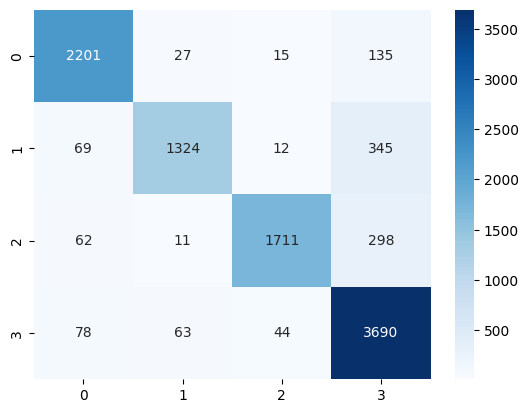

In [133]:
a_spacy_rf = train_and_predict(rfc, list(x_train_spacy), y_train_spacy, list(x_test_spacy), y_test_spacy)

Spacy Word Embeddings + Neural Networks

In [134]:
spacy_nn = keras.Sequential([
    keras.layers.InputLayer(input_shape=(96,)),
    keras.layers.Dense(48, activation='relu'),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(len(df_spacy['label_encoded'].unique()), activation='softmax')
])

spacy_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

d:\Softwares\DL\conda\envs\dl_venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [135]:
spacy_nn_x = np.array(list(x_train_spacy))
spacy_nn_y = np.array(y_train_spacy)
spacy_nn_x_test = np.array(list(x_test_spacy))
spacy_nn_y_test = np.array(y_test_spacy)
spacy_nn.fit(spacy_nn_x, spacy_nn_y, epochs=100, batch_size=128, validation_data=[spacy_nn_x_test, spacy_nn_y_test])

Epoch 1/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5637 - loss: 1.0320 - val_accuracy: 0.6403 - val_loss: 0.8857
Epoch 2/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6629 - loss: 0.8429 - val_accuracy: 0.6678 - val_loss: 0.8288
Epoch 3/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6924 - loss: 0.7916 - val_accuracy: 0.6929 - val_loss: 0.7856
Epoch 4/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7055 - loss: 0.7654 - val_accuracy: 0.7097 - val_loss: 0.7671
Epoch 5/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7157 - loss: 0.7445 - val_accuracy: 0.7175 - val_loss: 0.7526
Epoch 6/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7219 - loss: 0.7288 - val_accuracy: 0.7105 - val_loss: 0.7487
Epoch 7/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7252 - loss: 0.7182 - val_accuracy: 0.7222 - val_loss: 0.7331
Epoch 8/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7301 - loss: 0.7079 - val_accu

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step
Spacy NN Accuracy: 0.7906
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      2378
           1       0.85      0.71      0.78      1750
           2       0.78      0.66      0.72      2082
           3       0.72      0.88      0.80      3875

    accuracy                           0.79     10085
   macro avg       0.82      0.77      0.79     10085
weighted avg       0.80      0.79      0.79     10085



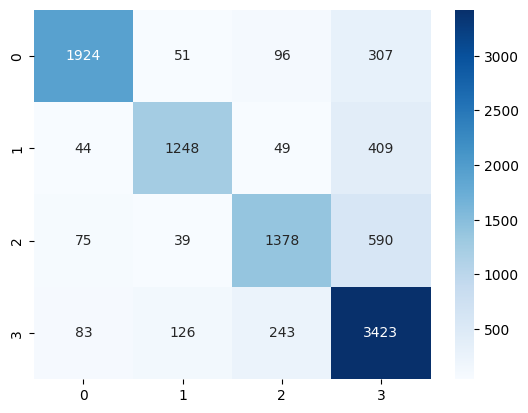

In [136]:
y_pred_nn_spacy = np.argmax(spacy_nn.predict(spacy_nn_x_test), axis=1)
a_spacy_nn = accuracy_score(spacy_nn_y_test, y_pred_nn_spacy)
print(f"Spacy NN Accuracy: {a_spacy_nn:.4f}")
confusion_matrix_report(spacy_nn_y_test, y_pred_nn_spacy)

FastText + RandomForest

In [115]:
df_fastext = df.copy()
df_fastext['label_encoded'] = LabelEncoder().fit_transform(df_fastext['Category'])
df_fastext.head()

,Category,Description,label_encoded
0,Household,paper plane design framed wall hanging motivat...,3
1,Household,saf floral framed painting wood 30 inch x 10 i...,3
2,Household,saf uv textured modern art print framed painti...,3
3,Household,saf flower print framed painting synthetic 135...,3
4,Household,incredible gifts india wooden happy birthday u...,3


In [121]:
ft_model = FastText(vector_size=100, window=5, min_count=1)
ft_model.build_vocab(corpus_iterable=[desc.split() for desc in df_fastext['Description']])
ft_model.train(
    corpus_iterable=[desc.split() for desc in df_fastext['Description']], 
    total_examples=ft_model.corpus_count,
    epochs=ft_model.epochs
)

(19188104, 19234470)

In [122]:
print(ft_model.wv.similarity('laptop', 'computer'))
print(ft_model.wv.similarity('laptop', 'boy'))

0.5283822
0.09515891


In [123]:
def document_vector(doc):
    words = doc.split()
    word_vectors = [ft_model.wv[word] for word in words if word in ft_model.wv]
    if len(word_vectors) == 0:
        return np.zeros(ft_model.vector_size)
    return np.mean(word_vectors, axis=0)

df_fastext['ft_embeddings'] = df_fastext['Description'].apply(document_vector)
df_fastext.head()

,Category,Description,label_encoded,ft_embeddings
0,Household,paper plane design framed wall hanging motivat...,3,"[1.0586219, 1.1731839, -0.17358065, -0.9003197..."
1,Household,saf floral framed painting wood 30 inch x 10 i...,3,"[0.27946952, 0.6977246, 0.30245468, -0.8616363..."
2,Household,saf uv textured modern art print framed painti...,3,"[0.27775902, 0.27884915, 0.06752358, -0.557517..."
3,Household,saf flower print framed painting synthetic 135...,3,"[0.5452509, 0.4510006, 0.0832455, -0.60160893,..."
4,Household,incredible gifts india wooden happy birthday u...,3,"[0.3684504, 0.6211245, -0.3084858, -0.52857774..."


In [124]:
x_train_ft, x_test_ft, y_train_ft, y_test_ft = train_test_split(
    df_fastext['ft_embeddings'],
    df_fastext['label_encoded'],
    test_size=0.2,
    random_state=42
)

x_train_ft.shape, x_test_ft.shape

((40339,), (10085,))

Training RandomForestClassifier...
Accuracy: 0.9611
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2378
           1       0.97      0.94      0.96      1750
           2       0.97      0.94      0.96      2082
           3       0.94      0.98      0.96      3875

    accuracy                           0.96     10085
   macro avg       0.97      0.96      0.96     10085
weighted avg       0.96      0.96      0.96     10085



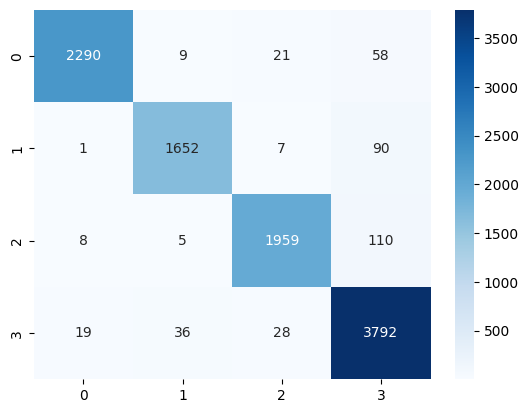

In [125]:
a_ft_rf = train_and_predict(rfc, list(x_train_ft), y_train_ft, list(x_test_ft), y_test_ft)

Genism FastText Embeddings + Neural Networks

In [126]:
ft_nn = keras.Sequential([
    keras.layers.InputLayer(input_shape=(100,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(len(df_fastext['label_encoded'].unique()), activation='softmax')
])

ft_nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

d:\Softwares\DL\conda\envs\dl_venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [127]:
x_train_ft_nn = np.array(list(x_train_ft))
y_train_ft_nn = np.array(y_train_ft)
x_test_ft_nn = np.array(list(x_test_ft))
y_test_ft_nn = np.array(y_test_ft)
ft_nn.fit(x_train_ft_nn, y_train_ft_nn, epochs=100, batch_size=128, validation_data=[x_test_ft_nn, y_test_ft_nn])

Epoch 1/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8648 - loss: 0.4142 - val_accuracy: 0.9053 - val_loss: 0.3116
Epoch 2/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9140 - loss: 0.2850 - val_accuracy: 0.9144 - val_loss: 0.2850
Epoch 3/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9216 - loss: 0.2605 - val_accuracy: 0.9193 - val_loss: 0.2680
Epoch 4/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9247 - loss: 0.2455 - val_accuracy: 0.9233 - val_loss: 0.2590
Epoch 5/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9310 - loss: 0.2299 - val_accuracy: 0.9245 - val_loss: 0.2480
Epoch 6/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9347 - loss: 0.2207 - val_accuracy: 0.9288 - val_loss: 0.2419
Epoch 7/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9373 - loss: 0.2126 - val_accuracy: 0.9322 - val_loss: 0.2316
Epoch 8/100
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9401 - loss: 0.2034 - val_accu

316/316 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step
FastText NN Accuracy: 0.9542
Confusion Matrix:

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2378
           1       0.96      0.97      0.97      1750
           2       0.93      0.96      0.94      2082
           3       0.96      0.95      0.95      3875

    accuracy                           0.95     10085
   macro avg       0.95      0.96      0.95     10085
weighted avg       0.95      0.95      0.95     10085



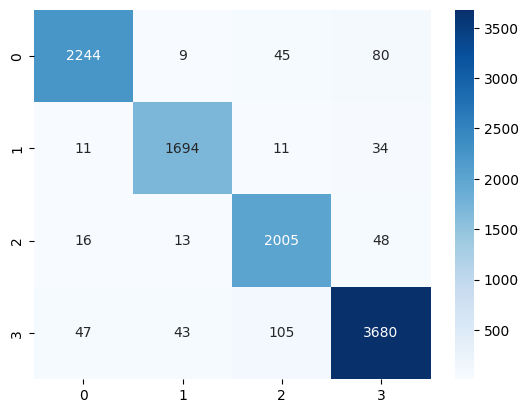

In [128]:
y_pred_ft_nn = np.argmax(ft_nn.predict(x_test_ft_nn), axis=1)
a_ft_nn = accuracy_score(y_test_ft_nn, y_pred_ft_nn)
print(f"FastText NN Accuracy: {a_ft_nn:.4f}")
confusion_matrix_report(y_test_ft_nn, y_pred_ft_nn)

All Models Accuracy Comparison

<Axes: title={'center': 'Model Accuracies'}, xlabel='Accuracy', ylabel='Models'>

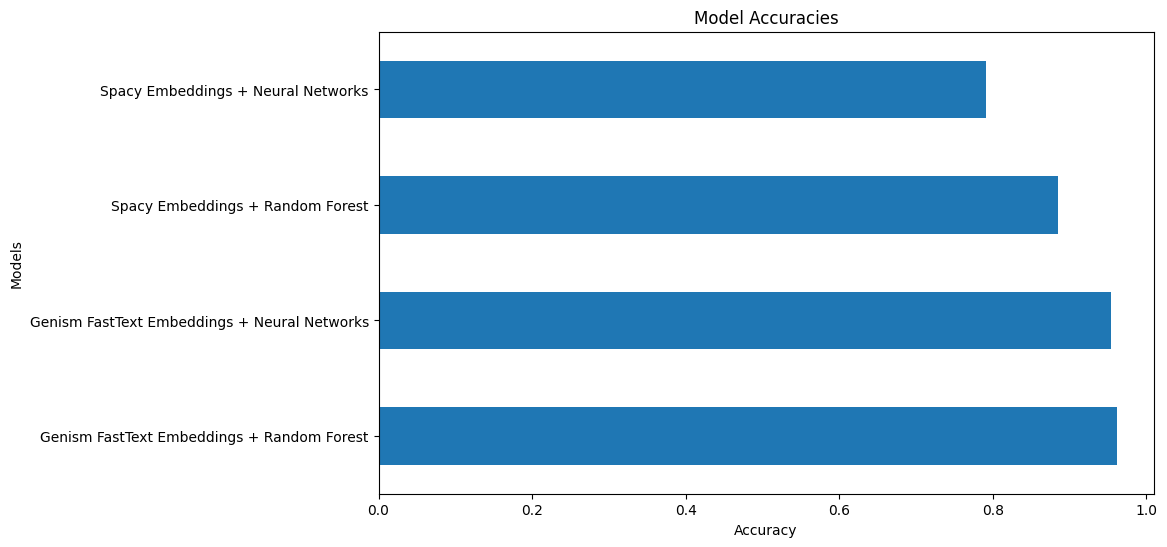

In [139]:
model_accuracies_dict = {
    "Spacy Embeddings + Random Forest": a_spacy_rf,
    "Spacy Embeddings + Neural Networks": a_spacy_nn,
    "Genism FastText Embeddings + Random Forest": a_ft_rf,
    "Genism FastText Embeddings + Neural Networks": a_ft_nn
}

# Histogram of model accuracies
model_accuracies = pd.Series(model_accuracies_dict)
model_accuracies.sort_values(ascending=False).plot.barh(title="Model Accuracies", xlabel="Accuracy", ylabel="Models", figsize=(10,6))